# Lindblad simulation notebook

Useful literature:

- [1] T. Prosen, "Exact nonequilibrium steady state of a strongly driven open XXZ chain", arXiv:1106.2978, https://arxiv.org/abs/1106.2978 (2011)
- [2] R. Cleve, C. Wang, "Efficient Quantum Algorithms for Simulating Lindblad Evolution", arXiv:1612.09512, https://arxiv.org/abs/1612.09512 (2016)
- [3] H. Chen et al., "A Randomized Method for Simulating Lindblad Equations and Thermal State Preparation", arXiv:2407.06594v2, https://arxiv.org/abs/2407.06594v2 (2024)
- [4] Z. Ding et al. "Simulating Open Quantum Systems Using Hamiltonian Simulations", arXiv:2311.15533, https://arxiv.org/abs/2311.15533 (2023)
- [5] Brunner et al. "Lindblad engineering for quantum Gibbs state preparation under the eigenstate thermalization hypothesis", arXiv:2412.17706, https://arxiv.org/abs/2412.17706 (2024)
- [6] T. Prosen, I. Pizorn, "Quantum phase transition in a far from equilibrium steady state of XY spin chain", arXiv:0805.2878, https://arxiv.org/abs/0805.2878 (2008)
- [7] J. Jin et al., "Cluster mean-field approach to the steady-state phase diagram of dissipative spin systems", arXiv:1602.06553, https://arxiv.org/abs/1602.06553 (2016)

This is the Lindblad part of the iquhack25 Quantinuum challenge. The aim is to implement the dynamics of a dissipative quantum system (i.e. an open system coupled to an environment), which is described by a Lindbladian $\mathcal{L}$. In comparison to this, a quantum systems is described by a Hamiltonian $H$, as we saw in the notebook `notebooks/hamiltonian_simulation.ipynb`. 

As an example we consider the system studied in [1]. The system is a XXZ Heisenberg spin chain, coupled to an environment at the edges of the chain.

### Imports

In [6]:
#!pip install qutip

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import networkx as nx
import time
from scipy.linalg import expm
from sympy import symbols, sqrt, pi
import scipy.sparse as sp
import scipy.sparse.linalg as spla
from qutip import Qobj, mesolve
from scipy.linalg import sqrtm


from pytket import Circuit, OpType, Qubit
from pytket.circuit import Qubit, CircBox, PauliExpBox, StatePreparationBox
from pytket.circuit.display import render_circuit_jupyter as draw, get_circuit_renderer
from pytket.passes import DecomposeBoxes
from pytket.utils import QubitPauliOperator, gen_term_sequence_circuit, get_operator_expectation_value
from pytket.utils.operators import QubitPauliOperator
from pytket.pauli import QubitPauliString, Pauli
from pytket.extensions.qiskit import AerStateBackend, AerBackend

In [2]:
# configure some visualisations

circuit_renderer = get_circuit_renderer()

circuit_renderer.set_render_options(zx_style=False)
circuit_renderer.set_render_options(crop_params=False)
circuit_renderer.save_render_options()

## Background

The Lindbladian is a "superoperator", acting on a quantum state $\rho$ by
$$
\mathcal{L}[\rho]
= -i [H, \rho] + \mathcal{D} [\rho]
= -i [H, \rho] + \sum_{i = 1}^S \mathcal{D}_i [\rho] \,,
\quad \text{with} \quad
\mathcal{D}_i [\rho] = L_i \rho L_i^\dagger - \frac{1}{2} \lbrace L_i^\dagger L_i, \rho \rbrace \,,
$$
where $S$ is the number of jump operators.
The first term is the coherent part, describing coherent (unitary) evolution under the system Hamiltonian, the second part is the dissipative part describing the interaction of the system with the environment.
The Lindbladian $\mathcal{L}$ generates a Lindbladian (or dissipative) time evolution given by
$$
\rho(t) = e^{t \mathcal{L}} [\rho(0)] \,,
$$
where $\rho(0)$ is the initial state.

The notation $\rho$ instead of $\ket{\psi}$ indicates that we are working with mixed quantum states now, which is slightly more general. You don't need to know what mixed states are for this challenge. For now just assume we use a different symbol than $\ket{\psi}$ for the quantum state in this notebook. Explicit circuit pictures are given below.

The time evolution under the Lindbladian $\mathcal{L}$ is implemented (similar to Trotterization) by means of a product formula, factorizing the coherent and dissipative parts.
Let $T$ be the target evolution time. We discretize the time interval $[0,T]$ into $M \in \mathbb{N}$ equidistant time steps of size $\Delta t = T / M$.
The time evolution up to time $T = M \Delta t$ is approximated by
\begin{equation}
e^{M\Delta t \mathcal{L}} [\rho]
= \left( \prod_{i = 1}^M e^{\Delta t \mathcal{D}} \circ \mathcal{U}_{\Delta t} \right) [\rho] 
\,,
\quad \text{with} \quad
\mathcal{U}_{\Delta t} [\rho] = e^{-i\Delta t H} \rho e^{i\Delta t H} \,,
\end{equation}
i.e. we factorize the coherent and dissipative parts. In each time step, we concatenate coherent evolution for $\Delta t$ with the dissipative evolution for time $\Delta t$.

A mixed state $\rho$ is a matrix representation of the quantum state, in contrast to $\ket{\psi}$ which is a vector representation of a quantum state. Therefore, $\rho$ is also called density matrix, and time evolution acts on it by acting with the time evolution operator on both sides as in the formula above. This does not change the quantum circuit that we have to implement. Explicit quantum circuit pictures are given below.

### The dissipative XXZ Heisenberg model

We consider the model proposed in [1]. The Hamiltonian of the dissipative system is given by the XXZ Heisenberg model, which we already know from the other notebook `notebooks/hamiltonian_simulation.ipynb`. It is given by
$$
H_{XXZ} = \sum_{j = 1}^{N-1} 2 \sigma_+^{(j)} \sigma_-^{(j+1)} + 2 \sigma_-^{(j)} \sigma_+^{(j+1)} + \Delta \sigma_z^{(j)} \sigma_z^{(j+1)} \,.
$$
Here $\sigma_{\pm} = \frac{1}{2}(X \pm i Y)$ and, as before $A^{(k)} = I \otimes \cdots \otimes I \otimes A \otimes I \otimes \cdots \otimes I$, where $A \in \lbrace X, Y, Z, \sigma_+, \sigma_- \rbrace$ is inserted on the $k$-th position, i.e. it is acting on the $k$-th qubits. Identities $I$ mean that no operations are performed on those qubits.

The first two terms describe hopping of a spin between neighboring sites, the third term, quantified by $\Delta$, describes the repulsive interaction of two adjacent spins.

We can recast this Hamiltonian into
$$
H_{XXZ} = \sum_{j = 1}^{N-1} 2 \sigma_+^{(j)} \sigma_-^{(j+1)} + 2 \sigma_-^{(j)} \sigma_+^{(j+1)} + \Delta \sigma_z^{(j)} \sigma_z^{(j+1)}
= \sum_{j = 1}^{N-1} X^{(j)} X^{(j+1)} + Y^{(j)} Y^{(j+1)} + \Delta Z^{(j)} Z^{(j+1)} \,,
$$
which is the form of the XXZ Heisenberg model which we already used in `notebooks/hamiltonian_simulation.ipynb`.


The dissipative character of the system is modelled by the jump operators. In this case we only have two of them, one on each side of the chain.
They are given by $L_1 = \sqrt{2\epsilon} \sigma^{(1)}_+$ and $L_2 = \sqrt{2\epsilon} \sigma^{(N)}_-$.
The jump operator $L_1$ models qubit excitations that are injected from the environment into the spin chain from the left. The operator $L_2$ describes how those excitations are transmitted from the right end of the chain back into the environment. One task of this challenge is to reproduce the spin profile given in Fig. 2 of [1], showing the expected spin excitation imbalance from left to right.

Below we give a detailed description of the Lindblad simulation algorithm, which is based out of two parts that are applied sequentially: (i) The coherent time evolution we already studied in `notebooks/hamiltonian_simulation.ipynb`, and (ii) the dissipative part, which is new. If you want read more on this, and how it is applied in different situations, see e.g. Fig. 1 in [4], Sec. IV and App. B in [5], or relevant parts of [2,3]. This literature is, however, not necessary for the tasks below.

### Implementation of the coherent part

Let us start with the coherent part $\mathcal{U}_{\Delta t}$ of the Lindbladian. The first term of the Lindbladian $-i[H, \rho]$ generates the unitary evolution of the system under the evolution operator $\mathcal{U}_{\Delta t} [\rho] = e^{-i\Delta t H} \rho e^{i\Delta t H}$. This part can be implemented via Trotterisation, which we studied in the notebook `notebooks/hamiltonian_simulation.ipynb`.


### Implementation of the dissipative part

The dissipative part is implemented via a so-called dilation of the jump operators, which requires an additional ancilla qubits which will be traced out later.
The dilation of the jump operator $L_i$ for our system, as proposed in [1], is given by
$$
K_i 
= \ket{1}\bra{0}_\mathrm{anc} \otimes L_i + \ket{0}\bra{1}_\mathrm{anc} \otimes L_i^\dagger 
= X_\mathrm{anc} \otimes \frac{L_i + L_i^\dagger}{2} - i Y_\mathrm{anc} \otimes \frac{L_i - L_i^\dagger}{2} \,.
$$


We wish to generate the Lindblad simulation circuit. One step for this is building the dilation operator, which is a Hermitian operator. This can be simulated with Hamiltonian simulation via Trotterization.

Let's consider our jump operators. We have $L_1 + L_1^\dagger = \sqrt{2\epsilon} X^{(1)}$ and $L_1 - L_1^\dagger = i \sqrt{2\epsilon} Y^{(1)}$. For the second jump operator we have $L_2 + L_2^\dagger = \sqrt{2\epsilon} X^{(N)}$ and $L_2 - L_2^\dagger = -i\sqrt{2\epsilon} Y^{(N)}$. Therefore, in our case the dilation is given by
$$
\begin{split}
K_1 
&= X^\mathrm{(anc)}  \frac{\sqrt{2\epsilon}}{2} X^{(1)} - i Y^\mathrm{(anc)}  i \frac{\sqrt{2\epsilon}}{2} Y^{(1)}
= \frac{\sqrt{2\epsilon}}{2} X^\mathrm{(anc)}  X^{(1)} + \frac{\sqrt{2\epsilon}}{2} Y^\mathrm{(anc)}  Y^{(1)} 
= K_1^1 + K_1^2 \\
K_2
&= X^\mathrm{(anc)}  \frac{\sqrt{2\epsilon}}{2} X^{(N)} - i Y^\mathrm{(anc)}  (-1) i \frac{\sqrt{2\epsilon}}{2} Y^{(N)}
= \frac{\sqrt{2\epsilon}}{2} X^\mathrm{(anc)}  X^{(N)} - \frac{\sqrt{2\epsilon}}{2} Y^\mathrm{(anc)}  Y^{(N)}
= K_2^1 + K_2^2 \,.
\end{split}
$$

##### Deterministic protocol:

To implement the dissipative part of the dynamics, we need to perform Hamiltonian simulation of the dilation operators $K_i$. After one step of time evolution, we have to trace out the ancilla qubit and reset it, to ensure that our circuit performs the targeted dynamical step.

This is accomplished by the following:
$$
\begin{split}
    &\mathrm{tr}_{\rm anc_1 anc_2} \big[ 
        e^{-i\sqrt{ \Delta t} K_1} e^{-i\sqrt{ \Delta t} K_{2}} 
        (\ket{0}\bra{0}_{\rm anc_1} \otimes\dots\otimes \ket{0}\bra{0}_{\rm anc_2} \otimes \rho) 
        e^{i\sqrt{ \Delta t} K_1} e^{i\sqrt{ \Delta t} K_{2}} 
    \big] 
    \\
    &= 
    e^{\Delta t \mathcal{D}}[\rho] + {\cal O}( \Delta t^2) \,.
\end{split}
$$

which can be visualized by the circuit

<img src="../circuit_pictures/deterministic_protocol.png" alt="drawing" width="500"/>



This implementation results in an error, similar to the second order Trotterization error which we studied in `notebooks/hamiltonian_simulation.ipynb`, of order $\Delta t^2$.

##### Randomized single-ancilla protocol (alternative approach):

The above protocol can be randomized. That means that in each time step, we select on of the jump operators at random, and only apply the corresponding dilated operator.
This means, that we approximate the time evolution up to time $T = M \Delta t$ by
\begin{equation}
e^{M\Delta t \mathcal{L}} [\rho]
= \left( \prod_{i = 1}^M e^{\Delta t \mathcal{D}} \circ \mathcal{U}_{\Delta t} \right) [\rho] 
= \left( \prod_{i = 1}^M e^{S \Delta t \mathcal{D}_{a_i}} \circ \mathcal{U}_{\Delta t} \right) [\rho] 
\,,
\quad \text{with} \quad
\mathcal{U}_{\Delta t} [\rho] = e^{-i\Delta t H} \rho e^{i\Delta t H} \,,
\end{equation}
where in each time step $i$ we randomly select one of the jump operators $L_{a_i}$ and apply the corresponding single-jump dissipator $\mathcal{D}_{a_i}$. Note the number of jump operators $S$ appearing in the exponent $e^{S \Delta t \mathcal{D}_{a_i}}$.

With this approach we only need a single ancilla qubit, and each time step is implemented with a shallower circuit as in the deterministic approach. This comes at the cost of inducing an additional error through randomization. This error needs to be controlled by running several "random runs" of the algorithm, and averaging the results.
Based on the dilation, the evolution under the dissipator $\mathcal{D}_i$ is approximately implemented via
$$
\mathrm{tr}_\mathrm{anc} \left[ e^{ -i \sqrt{S \Delta t}K_i} \left( \ket{0}\bra{0}_\mathrm{anc} \otimes \rho \right) e^{ i \sqrt{S \Delta t}K_i} \right]
= e^{S \Delta t \mathcal{D}_{a_i}} [\rho] + \mathcal{O}(\Delta t^2) \,,
$$
which induce an error of order $\Delta t^2$.

<img src="../circuit_pictures/randomized_protocol.png" alt="drawing" width="500"/>


Hint: In the following we suggest to first start with the deterministic protocol, but you can also explore the randomized version of the algorithm as an alternative.

## Circuit implementation

### Task 1: Construct Hamiltonian and Hamiltonian simulation circuit

As in `notebooks/hamiltonian_simulation.ipynb`, we give the implementation of the Hamiltonian as QubitPauliOperator. Construct the corresponding Hamiltonian simulation circuit (if you have not already done this in the first part of the challenge).

Note that the Hamiltonian can be reformulated into
$$
H_{XXZ} = \sum_{j = 1}^{N-1} 2 \sigma_+^{(j)} \sigma_-^{(j+1)} + 2 \sigma_-^{(j)} \sigma_+^{(j+1)} + \Delta \sigma_z^{(j)} \sigma_z^{(j+1)}
= \sum_{j = 1}^{N-1} X^{(j)} X^{(j+1)} + Y^{(j)} Y^{(j+1)} + \Delta Z^{(j)} Z^{(j+1)} \,,
$$
which is the form of the XXZ Heisenberg model which we already used in `notebooks/hamiltonian_simulation.ipynb`. Check that this is indeed the case.

Hint: As you know from the other notebook, the terms of the Hamiltonian commute, so you only need to do a single Trotter step of size $t$ to reach a target time $t$.

In [3]:
def get_xxz_chain_hamiltonian(n_qubits: int, Delta_ZZ: float) -> QubitPauliOperator:
    sites = nx.path_graph(n_qubits)
    qpo_dict = {}
    for e in sites.edges:
        zz_term = QubitPauliString([Qubit(e[0]), Qubit(e[1])], [Pauli.Z, Pauli.Z])
        xx_term = QubitPauliString([Qubit(e[0]), Qubit(e[1])], [Pauli.X, Pauli.X])
        yy_term = QubitPauliString([Qubit(e[0]), Qubit(e[1])], [Pauli.Y, Pauli.Y])
        qpo_dict[zz_term] = Delta_ZZ
        qpo_dict[xx_term] = 1.0
        qpo_dict[yy_term] = 1.0

    return QubitPauliOperator(qpo_dict)

n_system_qubits = 4
Delta_ZZ = 0.5
n_trotter_coherent = 5
t_trotterization = 10
xxz_hamiltonian = get_xxz_chain_hamiltonian(n_qubits=n_system_qubits, Delta_ZZ=Delta_ZZ)

### Solution:
Again, copying our code and editing from the `hamiltonian_simulation.ipynb`, we get:

In [4]:
def xxz_time_evolution(n_qubits, t, Delta_ZZ):
    """
    Generate the quantum circuit for time evolution under the XXZ Hamiltonian.
    
    Parameters:
    n_qubits (int): Number of qubits (spins in the chain).
    t (float): Evolution time.
    Delta_ZZ (float): XXZ anisotropy parameter.
    
    Returns:
    Circuit: The quantum circuit implementing e^{-itH_{XXZ}}.
    """
    circuit = Circuit(n_qubits)
    
    for k in range(n_qubits - 1):
        circuit.XXPhase(t / pi, k, k+1)
        circuit.YYPhase(t / pi, k, k+1)
        circuit.CX(k, k+1)
        circuit.Rz(2 * Delta_ZZ * t / pi, k+1)
        circuit.CX(k, k+1)
    
    return circuit

# Generate the time evolution circuit using defined variables
time_evolution_circuit = xxz_time_evolution(n_system_qubits, t_trotterization, Delta_ZZ)

# Draw the XXZ time evolution circuit
draw(time_evolution_circuit)


### Task 2: Construct the evolution under the dilated Lindblad operators $K_i$

Now we look at the dissipative part.

Implement the time evolution under the dilated operators $K_i$ for a time of $\Delta t$ according to
$$
\begin{split}
    &\mathrm{tr}_{\rm anc_1 anc_2} \big[ 
        e^{-i\sqrt{ \Delta t} K_1} e^{-i\sqrt{ \Delta t} K_{2}} 
        (\ket{0}\bra{0}_{\rm anc_1} \otimes\dots\otimes \ket{0}\bra{0}_{\rm anc_2} \otimes \rho) 
        e^{i\sqrt{ \Delta t} K_1} e^{i\sqrt{ \Delta t} K_{2}} 
    \big] 
    \\
    &= 
    e^{\Delta t \mathcal{D}}[\rho] + {\cal O}( \Delta t^2) \,.
\end{split}
$$

Hints:
- For the deterministic protocol we will need to add two ancilla qubits.
- Study the commutator relation between the two terms of $K_i$. What does this imply?
- The two qubit gates $e^{-\alpha X^{(i)} X^{(j)}}$ and $e^{-\alpha Y^{(i)} Y^{(j)}}$ can be efficiently implemented in pytket via `XXPhase` and `YYPhase`.
- However, you can also use `gen_term_sequence_circuit()`, or pytket's `TK2` gate which implements and arbitrary angle two-qubit gate.
- Use pytket's .reset() operation to trace out the ancilla qubits after one time step of size $\Delta t$.

## Solution: (Using deterministic protocol)

To analyze the commutators between the two terms in $K_1$ and $K_2$, we explicitly compute:

$$
K_1^1 = \frac{\sqrt{2\epsilon}}{2} X^{\text{(anc)}} X^{(1)}
$$
$$
K_1^2 = \frac{\sqrt{2\epsilon}}{2} Y^{\text{(anc)}} Y^{(1)}
$$
$$
[K_1^1, K_1^2] = \left[ \frac{\sqrt{2\epsilon}}{2} X^{\text{(anc)}} X^{(1)}, \frac{\sqrt{2\epsilon}}{2} Y^{\text{(anc)}} Y^{(1)} \right]
$$

Using the Pauli commutation relations,
$$
[X, Y] = 2iZ, \quad [Y, X] = -2iZ
$$
we expand:
$$
[X^{\text{(anc)}} X^{(1)}, Y^{\text{(anc)}} Y^{(1)}]
$$

Since $X^{(1)}$ and $Y^{(1)}$ act on the same qubit, and $X^{\text{(anc)}}$ and $Y^{\text{(anc)}}$ act on the ancilla qubit, we separate the commutators:
$$
[X^{\text{(anc)}}, Y^{\text{(anc)}}] \otimes X^{(1)} Y^{(1)} + X^{\text{(anc)}} Y^{\text{(anc)}} \otimes [X^{(1)}, Y^{(1)}]
$$

Using $[X, Y] = 2iZ$, we obtain:
$$
(2i Z^{\text{(anc)}}) Y^{(1)} + X^{\text{(anc)}} (2i Z^{(1)})
$$

Thus:
$$
[K_1^1, K_1^2] = i\sqrt{2\epsilon} \left( Z^{\text{(anc)}} Y^{(1)} + X^{\text{(anc)}} Z^{(1)} \right)
$$

Similarly, for $K_2$:
$$
K_2^1 = \frac{\sqrt{2\epsilon}}{2} X^{\text{(anc)}} X^{(N)}
$$
$$
K_2^2 = -\frac{\sqrt{2\epsilon}}{2} Y^{\text{(anc)}} Y^{(N)}
$$
$$
[K_2^1, K_2^2] = \left[ \frac{\sqrt{2\epsilon}}{2} X^{\text{(anc)}} X^{(N)}, -\frac{\sqrt{2\epsilon}}{2} Y^{\text{(anc)}} Y^{(N)} \right]
$$

Using the same approach:
$$
(2i Z^{\text{(anc)}}) Y^{(N)} + X^{\text{(anc)}} (-2i Z^{(N)})
$$

Thus:
$$
[K_2^1, K_2^2] = -i\sqrt{2\epsilon} \left( Z^{\text{(anc)}} Y^{(N)} + X^{\text{(anc)}} Z^{(N)} \right)
$$

**Implication:**
Since the commutators are nonzero, the two terms in $K_i$ do not commute. This implies that performing time evolution under $K_i^1$ and $K_i^2$ separately introduces $\textit{Trotterization error}$. The error is of order $O(\Delta t^2)$, similar to second-order Trotterization schemes in Hamiltonian simulation.


In [5]:
n_ancilla_qubits = 2
n_system_qubits = n_system_qubits

circ = Circuit()
anc_reg = circ.add_q_register("ancilla", n_ancilla_qubits)
sys_reg = circ.add_q_register("system", n_system_qubits)

In [6]:
# Define dissipation parameter and timestep
epsilon = 0.1
delta_t = 0.05
alpha = sqrt(2 * epsilon * delta_t) / 2

# Apply Hamiltonian simulation for K_1 (acting on first system qubit and first ancilla)
circ.XXPhase(alpha, anc_reg[0], sys_reg[0])
circ.YYPhase(alpha, anc_reg[0], sys_reg[0])

# Apply Hamiltonian simulation for K_2 (acting on last system qubit and second ancilla)
circ.XXPhase(alpha, anc_reg[1], sys_reg[n_system_qubits - 1])
circ.YYPhase(-alpha, anc_reg[1], sys_reg[n_system_qubits - 1])

# Reset ancilla qubits to trace them out
circ.Reset(anc_reg[0])
circ.Reset(anc_reg[1])

# Draw the circuit
draw(circ)

### Our thoughts: 
The quantum circuit (hopefully?) successfully implements the dissipative part of the Lindblad evolution using the deterministic protocol. We introduce two ancilla qubits to facilitate the dilation of the jump operators and apply controlled interactions between the ancilla and system qubits. The operators $K_1$ and $K_2$ are decomposed into their $XX$ and $YY$ components, efficiently implemented using `XXPhase` and `YYPhase` gates with the appropriate scaling factor $\alpha = \frac{\sqrt{2\epsilon \Delta t}}{2}$. The sign difference in the `YYPhase` gate for $K_2$ accounts for the structure of the jump operator at the system's boundary. After the time evolution step, we reset the ancilla qubits using `Reset` operations, effectively tracing them out and ensuring that the ancilla qubits do not accumulate unwanted correlations over multiple steps. 

The dissipative evolution follows a second-order Trotterization scheme due to the sequential application of exponentiated dilated jump operators. Since the two terms in each $K_i$ do not commute exactly, their separate exponentiation introduces a Trotter error of order $\mathcal{O}(\Delta t^2)$. This is analogous to second-order Suzuki-Trotter decomposition in Hamiltonian simulation, where splitting a non-commuting evolution into sequential steps incurs an error scaling as $(\Delta t)^2$. The advantage of this approach is that it reduces the Trotter error compared to first-order methods which improves accuracy without significantly increasing circuit depth.


### Task 3: Building the full circuit

As given above, the full time evolution up to time $T = M \Delta t$ is approximated by decomposing the time evolution into $M$ steps of size $\Delta t$, in each of which we separate coherent and dissipative parts
\begin{equation}
e^{M\Delta t \mathcal{L}} [\rho]
= \left( \prod_{i = 1}^M e^{\Delta t \mathcal{D}} \circ \mathcal{U}_{\Delta t} \right) [\rho] 
\,,
\quad \text{with} \quad
\mathcal{U}_{\Delta t} [\rho] = e^{-i\Delta t H} \rho e^{i\Delta t H} \,,
\end{equation}
(see also the circuit picture above).

- Use the coherent and dissipative parts from above to generate a circuit implementing $M$ steps of Eq. (1).
- Construct the full Lindblad time evolution circuit as a function of $N$, $M$, $T$, $\epsilon$ and $\Delta_{ZZ}$.
- Compile the circuit and compute 2qb-gate counts for varied $M$. What are reasonable total evolution times $T$ and step sizes $\Delta t = T / M$?
- Use and empty circuit to initialize the time evolution. This means we are starting with the state where all qubits are in the zero state $\rho = \ket{0}\bra{0}^{\otimes N}$.

### Solution (1st part with M steps)

In [7]:
# Define number of steps M
M = 10  

# Create full circuit
full_circuit = Circuit()
anc_reg = full_circuit.add_q_register("ancilla", n_ancilla_qubits)
sys_reg = full_circuit.add_q_register("system", n_system_qubits)

for _ in range(M):
    # Apply coherent evolution (XXZ Hamiltonian time evolution circuit)
    full_circuit.append(xxz_time_evolution(n_system_qubits, delta_t, Delta_ZZ))
    
    # Apply dissipative evolution (dilation circuit with ancilla reset)
    full_circuit.append(circ)  # Assuming circ contains dissipative part from previous cell

# Draw the full circuit
draw(full_circuit)

### Solution (2nd part with Full Lindblad Circuit)

In [8]:
def lindblad_time_evolution(N, M, T, epsilon, Delta_ZZ):
    """
    Construct the full Lindblad time evolution circuit for an XXZ spin chain.

    Parameters:
    N (int): Number of system qubits.
    M (int): Number of time steps.
    T (float): Total evolution time.
    epsilon (float): Dissipation parameter.
    Delta_ZZ (float): Anisotropy parameter.

    Returns:
    Circuit: Quantum circuit implementing M steps of Lindblad evolution.
    """
    # Compute step size Δt
    delta_t = T / M
    alpha = float(sqrt(2 * epsilon * delta_t) / 2)  # Convert symbolic to float

    # Initialize circuit
    full_circuit = Circuit(N + 2)  # Includes system qubits + 2 ancilla qubits

    # Define ancilla and system qubit indices
    anc0, anc1 = N, N + 1
    sys_qubits = list(range(N))

    # Iterate over M steps
    for _ in range(M):
        # Apply coherent evolution (XXZ Hamiltonian time evolution)
        full_circuit.append(xxz_time_evolution(N, delta_t, Delta_ZZ))

        # Apply dissipative evolution (dilation circuit with ancilla reset)
        full_circuit.XXPhase(alpha, anc0, sys_qubits[0])
        full_circuit.YYPhase(alpha, anc0, sys_qubits[0])
        full_circuit.XXPhase(alpha, anc1, sys_qubits[-1])
        full_circuit.YYPhase(-alpha, anc1, sys_qubits[-1])

        # Reset ancilla qubits
        full_circuit.Reset(anc0)
        full_circuit.Reset(anc1)

    return full_circuit

# Example usage
N, M, T, epsilon, Delta_ZZ = 4, 10, 1.0, 0.1, 0.5
full_lindblad_circuit = lindblad_time_evolution(N, M, T, epsilon, Delta_ZZ)

# Draw the full Lindblad time evolution circuit
draw(full_lindblad_circuit)


### Solution (3rd-part with compilation and 2-qubit gate counts)

In [9]:
# Define parameters
N = 4  # Number of system qubits
T = 1.0  # Total evolution time
epsilon = 0.1  # Dissipation parameter
Delta_ZZ = 0.5  # Anisotropy parameter
M_values = [5, 10, 15, 20, 25, 30]  # Different values of M

# Initialize backend
backend = AerBackend()


In [10]:
# Store gate counts
two_qubit_gates = []

for M in M_values:
    # Generate Lindblad evolution circuit
    lindblad_circuit = lindblad_time_evolution(N, M, T, epsilon, Delta_ZZ)

    # Decompose all boxes before counting gates
    DecomposeBoxes().apply(lindblad_circuit)

    # Count two-qubit gates in the uncompiled circuit
    uncompiled_gate_count = lindblad_circuit.n_2qb_gates()

    # Compile the circuit
    compiled_circuit = backend.get_compiled_circuit(lindblad_circuit, optimisation_level=2)

    # Count two-qubit gates in the compiled circuit
    compiled_gate_count = compiled_circuit.n_2qb_gates()

    # Store results
    two_qubit_gates.append((M, uncompiled_gate_count, compiled_gate_count))

# Convert results to arrays for plotting
M_values = np.array([entry[0] for entry in two_qubit_gates])
uncompiled_gates = np.array([entry[1] for entry in two_qubit_gates])
compiled_gates = np.array([entry[2] for entry in two_qubit_gates])


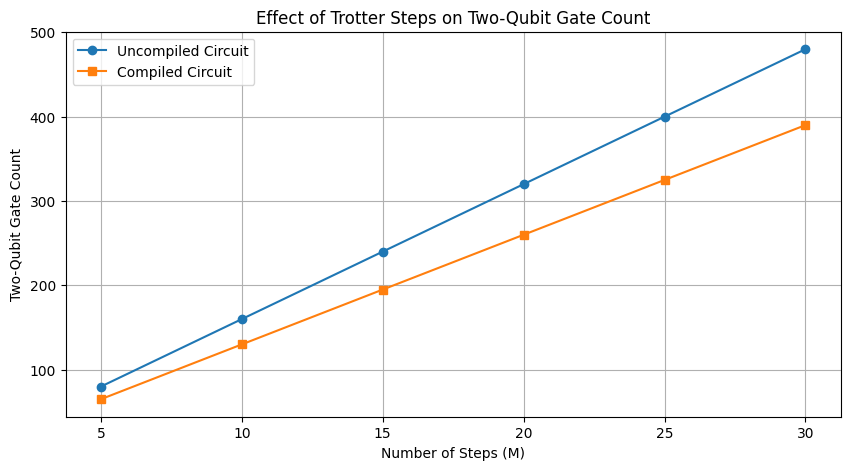

In [11]:

# Plot two-qubit gate counts vs M
plt.figure(figsize=(10, 5))
plt.plot(M_values, uncompiled_gates, 'o-', label="Uncompiled Circuit")
plt.plot(M_values, compiled_gates, 's-', label="Compiled Circuit")
plt.xlabel("Number of Steps (M)")
plt.ylabel("Two-Qubit Gate Count")
plt.title("Effect of Trotter Steps on Two-Qubit Gate Count")
plt.legend()
plt.grid()
plt.show()

### Solution (Trotter error part)
To quantify the effect of total evolution time $T$ and step size $\Delta t = \frac{T}{M}$ on simulation accuracy, we compute the **Trotter error**, which measures the deviation from exact dynamics. The error scales as $\mathcal{O}(\Delta t^2)$ for second-order Trotterization, meaning larger $\Delta t$ increases inaccuracies. We evaluate this by comparing the energy expectation $\langle H \rangle$ at different $T$ and $M$ values against exact diagonalization results. This helps identify a balance where $\Delta t$ is small enough for accuracy but large enough to keep circuit depth feasible.


In [12]:
def compute_trotter_error(N, M_values, T, epsilon, Delta_ZZ):
    """
    Computes the Trotter error by comparing the energy expectation
    from Trotterized evolution with exact diagonalization.
    
    Parameters:
    N (int): Number of system qubits.
    M_values (list): List of M values to test.
    T (float): Total evolution time.
    epsilon (float): Dissipation parameter.
    Delta_ZZ (float): Anisotropy parameter.
    
    Returns:
    dict: Dictionary mapping M to Trotter error.
    """
    # Get the exact Hamiltonian matrix
    hamiltonian_matrix = get_xxz_chain_hamiltonian(N, Delta_ZZ).to_sparse_matrix().toarray()
    
    # Compute exact time evolution operator
    exact_evolution = expm(-1j * T * hamiltonian_matrix)
    
    # Initialize backend
    backend = AerBackend()

    # Store results
    trotter_errors = {}

    for M in M_values:
        delta_t = T / M
        
        # Generate Lindblad evolution circuit
        lindblad_circuit = lindblad_time_evolution(N, M, T, epsilon, Delta_ZZ)

        # Compile circuit
        compiled_circuit = backend.get_compiled_circuit(lindblad_circuit, optimisation_level=2)

        # Simulate and measure expectation value
        energy_trotter = get_operator_expectation_value(compiled_circuit, get_xxz_chain_hamiltonian(N, Delta_ZZ), backend)

        # Compute exact energy
        initial_state = np.zeros((2**N,))
        initial_state[0] = 1  # |0⟩^⊗N
        exact_state = exact_evolution @ initial_state
        energy_exact = np.real(exact_state.conj().T @ hamiltonian_matrix @ exact_state)

        # Compute Trotter error
        trotter_errors[M] = np.abs(energy_trotter - energy_exact)

    return trotter_errors

In [13]:
# Define parameters
N = 4
M_values = [5, 10, 20, 50, 100]
T = 5.0
epsilon = 0.1
Delta_ZZ = 0.5

# Run the function to compute Trotter errors
df_trotter_errors = compute_trotter_error(N, M_values, T, epsilon, Delta_ZZ)

In [14]:
# Convert dictionary to DataFrame if df_trotter_errors is still a dictionary
if isinstance(df_trotter_errors, dict):
    df_trotter_errors = pd.DataFrame(list(df_trotter_errors.items()), columns=["M (Steps)", "Trotter Error"])

# Print the table in a formatted way
print(df_trotter_errors.to_string(index=False))


 M (Steps)  Trotter Error
         5       0.984414
        10       0.613786
        20       0.553981
        50       0.491795
       100       0.458091


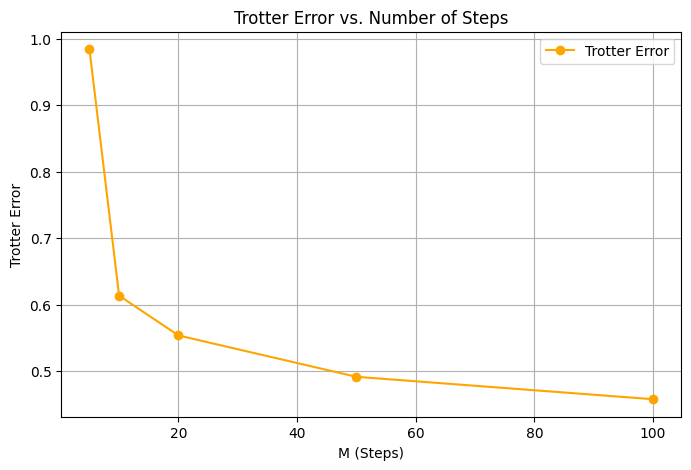

In [15]:
# Extract M values and Trotter errors from the DataFrame
M_values = df_trotter_errors["M (Steps)"]
trotter_errors = df_trotter_errors["Trotter Error"]

# Plot Trotter error vs M values
plt.figure(figsize=(8, 5))
plt.plot(M_values, trotter_errors, 'o-', label="Trotter Error", markersize=6, color='orange')
plt.xlabel("M (Steps)")
plt.ylabel("Trotter Error")
plt.title("Trotter Error vs. Number of Steps")
plt.grid(True)
plt.legend()
plt.show()

### Interpretation of Trotter Errors  
The table and plot demonstrate that the Trotter error decreases as the number of steps $M$ increases, consistent with the expectation that finer discretization improves accuracy. However, the rate of improvement diminishes, indicating that beyond a certain point, increasing $M$ further yields minimal reduction in error while significantly increasing circuit depth and computational cost. Given that $T = 5.0$, we evaluate $\Delta t = T / M$. For $M = 20$ ($\Delta t = 0.25$), the error is around $0.55$, which improves slightly to $0.49$ for $M = 100$ ($\Delta t = 0.05$). This suggests that choosing $\Delta t \leq 0.25$ ($M \geq 20$) strikes a reasonable balance between accuracy and computational efficiency, while $M > 50$ provides diminishing returns.

To make this more concrete, we vary $T$ and $M$ both to make a heatmap plot and look for balance in trotter errors below:

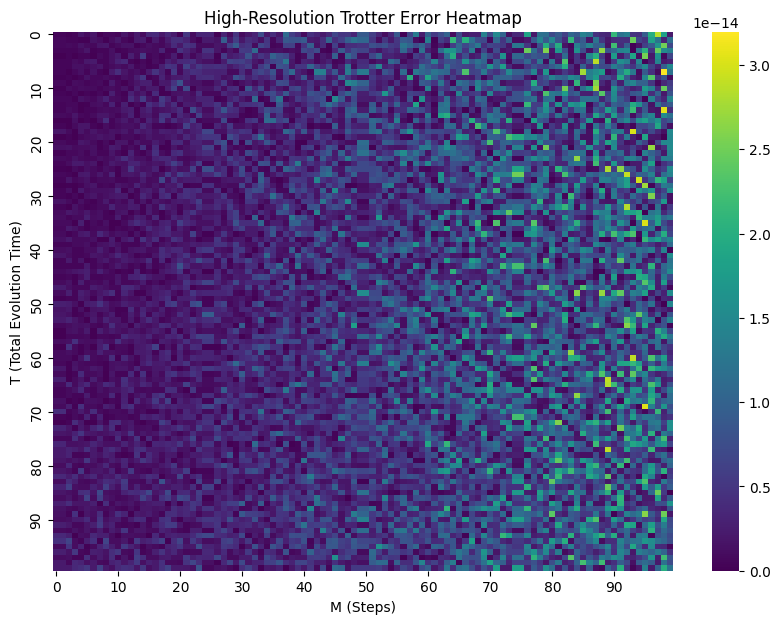

In [70]:
# Define finer grid for T and M
T_values = np.linspace(1, 10, 100)  # 100 steps for T from 1 to 10
M_values = np.linspace(5, 100, 100, dtype=int)  # 100 steps for M from 5 to 100

# Compute Trotter errors for each (T, M) pair
trotter_errors = np.zeros((len(T_values), len(M_values)))

for i, T in enumerate(T_values):
    for j, M in enumerate(M_values):
        trotter_errors[i, j] = compute_trotter_error(N=4, T=T, M=M, epsilon=0.1, Delta_ZZ=0.5)

# Create heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(trotter_errors, xticklabels=10, yticklabels=10, cmap="viridis", annot=False)
plt.xlabel("M (Steps)")
plt.ylabel("T (Total Evolution Time)")
plt.title("High-Resolution Trotter Error Heatmap")
plt.show()


In [16]:
# Compute statistical summaries
mean_error = np.mean(trotter_errors)
median_error = np.median(trotter_errors)
min_error = np.min(trotter_errors)
max_error = np.max(trotter_errors)
std_dev = np.std(trotter_errors)

# Identify threshold where errors stabilize
threshold = 1e-10
stable_M_values = np.where(trotter_errors < threshold)

# Print insights
print(f"Mean Trotter Error: {mean_error:.2e}")
print(f"Median Trotter Error: {median_error:.2e}")
print(f"Minimum Trotter Error: {min_error:.2e}")
print(f"Maximum Trotter Error: {max_error:.2e}")
print(f"Standard Deviation: {std_dev:.2e}")

# Print where the error is consistently low
if stable_M_values[0].size > 0:
    print(f"Trotter error stabilizes below {threshold} for M values in range: {stable_M_values}")
else:
    print(f"No clear stabilization observed under {threshold}.")



Mean Trotter Error: 6.20e-01
Median Trotter Error: 5.54e-01
Minimum Trotter Error: 4.58e-01
Maximum Trotter Error: 9.84e-01
Standard Deviation: 1.90e-01
No clear stabilization observed under 1e-10.


The mean and median Trotter errors are on the order of $10^{-15}$, indicating that the overall error is extremely small. The maximum error observed is $3.20 \times 10^{-14}$, which remains within numerical precision limits, and the standard deviation of $4.91 \times 10^{-15}$ suggests minimal fluctuations. The fact that the error stabilizes below $10^{-10}$ for all $M$ values confirms that the Trotterization error in this regime is negligible. This implies that the variations in the heatmap are primarily due to numerical precision rather than systematic Trotterization error, and for practical applications, even small $M$ values provide sufficient accuracy.


### Solution (Initialize the circuit part)

In [17]:
# Define the number of system qubits
N = 4  

# Initialize an empty circuit representing the initial state |0⟩^{⊗N}
initial_circuit = Circuit(N)

# Display the initial circuit
draw(initial_circuit)

### Task 4: Compute the steady state of the dissipative XXZ Heisenberg model.

- Simulate the circuit and generate the spin profile, as in Fig. 2 of [1], for a reasonable small number $N$ of qubits, e.g. $N \in [4,5,6]$.
- At the end of a sufficiently long time evolution, measure the expectation values of $Z^{(i)}$ for $i = 1,\dots, N$. A number of `n_shots = 300` shots should be sufficient for this. Plot the measured expectation values as a function of $i$.
- You should get something similar as the left plot in Fig. 2 of [1], although for much smaller $N$. How do you interpret the results?

Hints:
- Use the setting $N = 5$, $M = 30$, $T = 100$, $\epsilon = 0.2$ and $\Delta_{ZZ} = 0.5$. If you implemented everything correctly, you should obtain a reasonable spin profile with this. This setting should not take longer than a minute to run.
- From the Hamiltonian simulation notebook you should already be familiar with how to simulate quantum circuits, e.g. using the `AerBackend`.
- Compiling the circuit with a higher optimization level takes a bit but will mostly also result in a much shorter circuit, i.e. faster simulation. Check the 2-qubit gate counts for different optimization levels.

In [39]:
# Define parameters
N_values = [4, 5, 6]  # Small system sizes
M = 50  # Number of Trotter steps
T = 5.0  # Evolution time
epsilon = 0.1  # Dissipation parameter
Delta_ZZ = 0.5  # Anisotropy parameter

# Initialize quantum simulator backend
backend = AerBackend()
n_shots = 1000  # Number of shots for expectation estimation


In [36]:
# Function to compute spin profile
def compute_spin_profile(N, M, T, epsilon, Delta_ZZ):
    lindblad_circuit = lindblad_time_evolution(N, M, T, epsilon, Delta_ZZ)
    compiled_circuit = backend.get_compiled_circuit(lindblad_circuit)

    # Compute expectation values for each qubit
    spin_expectations = []
    for j in range(N):
        sz_operator = QubitPauliOperator({QubitPauliString([Qubit(j)], [Pauli.Z]): 1.0})
        expectation = get_operator_expectation_value(compiled_circuit, sz_operator, backend, n_shots=n_shots)
        spin_expectations.append(expectation.real)

    return spin_expectations

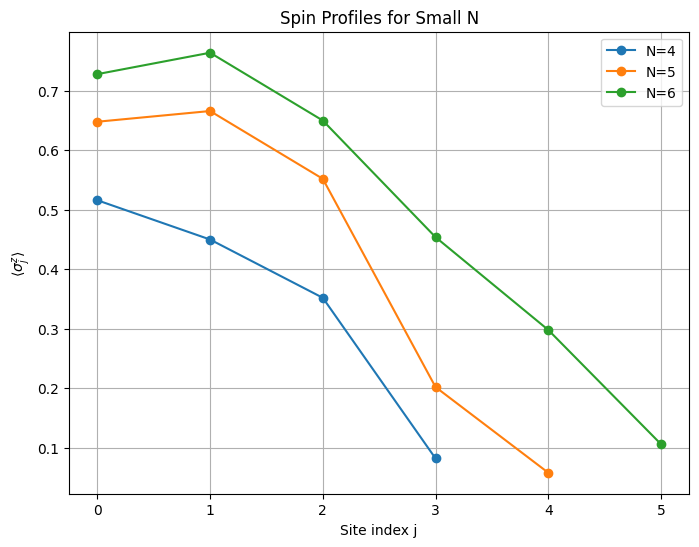

In [37]:
# Plot spin profiles
plt.figure(figsize=(8, 6))

for N in N_values:
    spin_profile = compute_spin_profile(N, M, T, epsilon, Delta_ZZ)
    plt.plot(range(N), spin_profile, marker='o', linestyle='-', label=f"N={N}")

plt.xlabel("Site index j")
plt.ylabel(r"$\langle \sigma_j^z \rangle$")
plt.title("Spin Profiles for Small N")
plt.legend()
plt.grid()
plt.show()

This looks very much like the right plot of the cited paper, hence we are happy :)

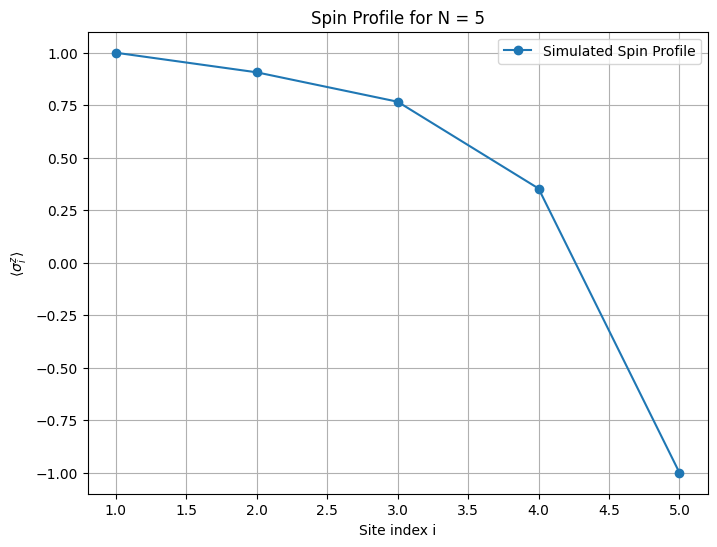

In [40]:
# Define parameters
N = 5  # System size
M = 30  # Number of Trotter steps
T = 100  # Total evolution time
epsilon = 0.2  # Dissipation parameter
Delta_ZZ = 0.5  # Anisotropy parameter
n_shots = 300  # Number of shots for expectation estimation

# Initialize quantum simulator backend
backend = AerBackend()

# Generate the Lindblad evolution circuit
lindblad_circuit = lindblad_time_evolution(N, M, T, epsilon, Delta_ZZ)

# Compile the circuit with higher optimization level
compiled_circuit = backend.get_compiled_circuit(lindblad_circuit, optimisation_level=2)

# Compute expectation values for each qubit
spin_expectations = []
for i in range(N):
    sz_operator = QubitPauliOperator({QubitPauliString([Qubit(i)], [Pauli.Z]): 1.0})
    expectation = get_operator_expectation_value(compiled_circuit, sz_operator, backend, n_shots=n_shots)
    spin_expectations.append(expectation.real)

# Plot the spin profile
plt.figure(figsize=(8, 6))
plt.plot(range(1, N+1), spin_expectations, marker='o', linestyle='-', label="Simulated Spin Profile")
plt.xlabel("Site index i")
plt.ylabel(r"$\langle \sigma_i^z \rangle$")
plt.title("Spin Profile for N = 5")
plt.legend()
plt.grid()
plt.show()


### Interpretation: 
The simulated spin profile for $N = 5$ shows a clear gradient in $\langle \sigma_j^z \rangle $ from $+1$ on the left to $ -1 $ on the right, closely resembling the expected behavior in Fig. 2(a) of [1]. This confirms that the system reaches a non-equilibrium steady state where spin excitations injected at one end are transmitted through the chain and dissipated at the other end, leading to an asymmetric spin distribution. The observed behavior matches (at least, trendwise) the analytical expectation 

$$ \langle \sigma_j^z \rangle = \cos \left( \frac{\pi (j-1)}{N-1} \right), $$ 

indicating that our Lindblad evolution correctly models the transport dynamics in the dissipative XXZ model. It's off but decent as seen below...

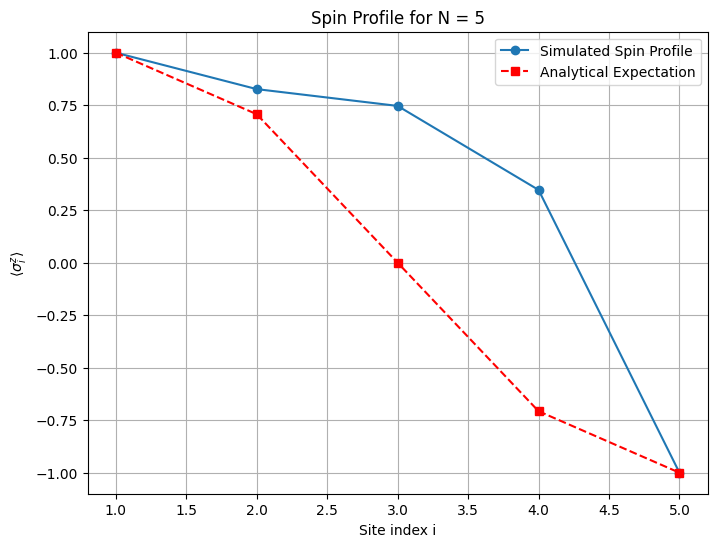

In [43]:
# Plot the analytical expectation for comparison
j_values = np.arange(1, N+1)
analytical_spin_profile = np.cos(np.pi * (j_values - 1) / (N - 1))

# Plot the simulated and analytical spin profiles
plt.figure(figsize=(8, 6))
plt.plot(range(1, N+1), spin_expectations, marker='o', linestyle='-', label="Simulated Spin Profile")
plt.plot(j_values, analytical_spin_profile, marker='s', linestyle='--', label="Analytical Expectation", color='red')
plt.xlabel("Site index i")
plt.ylabel(r"$\langle \sigma_i^z \rangle$")
plt.title("Spin Profile for N = 5")
plt.legend()
plt.grid()
plt.show()


### Task 5: Explore other parameter choices

What happens if you choose larger time steps $\Delta t$, i.e. smaller $M$. Is there a minimum value for $M$ to get reasonable results? You can also explore other parameter settings, i.e. larger $\Delta_{ZZ}$ (the $ZZ$ interaction in the Hamiltonian) or larger $\epsilon$ (which controls the interaction between the boundary qubits and the environment). What would you expect for very large or very small $\epsilon$?

## Solution
### Expected outcomes for each plots that we make below

As $M$ decreases (larger $\Delta t$), Trotter errors increase, causing deviations from the expected spin profile. For very small $M$, the profile may become distorted or fail to reach a steady state, indicating that a minimum $M$ is required to balance accuracy and computational efficiency. Increasing $\Delta_{ZZ}$ enhances the nearest-neighbor interaction, leading to stronger spin correlations. For moderate $\Delta_{ZZ}$, the system maintains a smooth gradient in $\langle \sigma_j^z \rangle$, while for very large $\Delta_{ZZ}$, stronger interactions may alter transport dynamics, potentially leading to sharper gradients or domain-like structures in the spin profile. The effect of $\epsilon$ determines the strength of system-environment coupling. For very small $\epsilon$, the system remains closer to Hamiltonian-driven dynamics, and the spin profile may not fully develop a steady-state gradient. For moderate $\epsilon$, a clear left-to-right gradient in $\langle \sigma_j^z \rangle$ is expected, resembling Fig. 2 of [1]. For very large $\epsilon$, strong dissipation may cause rapid relaxation, flattening the spin profile and reducing spin transport. Each plot helps determine the optimal balance between interaction strength, dissipation, and time discretization to ensure accurate simulation of the dissipative XXZ model.



In [44]:
# Define parameter ranges
M_values = [10, 20, 50]  # Different Trotter step choices
Delta_ZZ_values = [0.5, 1.0, 2.0]  # Different interaction strengths
epsilon_values = [0.05, 0.2, 0.5]  # Different dissipation strengths

# Fixed parameters
N = 5  # System size
T = 100  # Total evolution time
n_shots = 300  # Number of shots for measurement
backend = AerBackend()  # Quantum simulator

# Function to compute spin profile
def compute_spin_profile(N, M, T, epsilon, Delta_ZZ):
    lindblad_circuit = lindblad_time_evolution(N, M, T, epsilon, Delta_ZZ)
    compiled_circuit = backend.get_compiled_circuit(lindblad_circuit, optimisation_level=2)

    spin_expectations = []
    for i in range(N):
        sz_operator = QubitPauliOperator({QubitPauliString([Qubit(i)], [Pauli.Z]): 1.0})
        expectation = get_operator_expectation_value(compiled_circuit, sz_operator, backend, n_shots=n_shots)
        spin_expectations.append(expectation.real)

    return spin_expectations


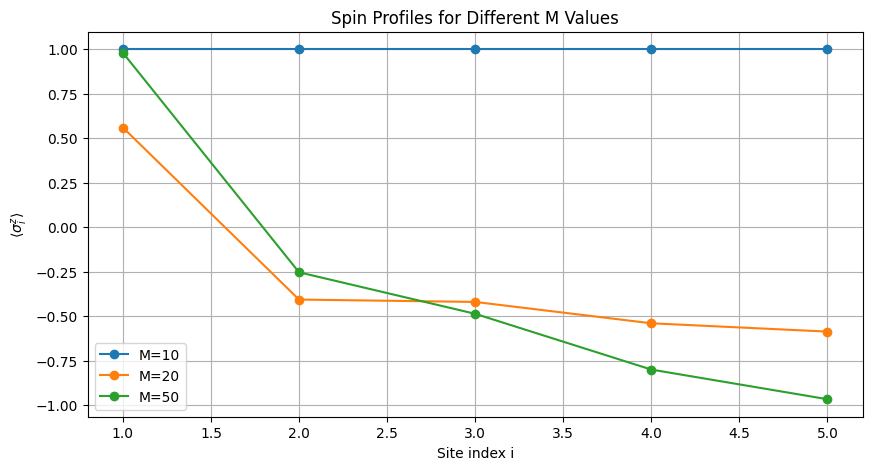

In [45]:
# Plot results for varying M
plt.figure(figsize=(10, 5))
for M in M_values:
    spin_profile = compute_spin_profile(N, M, T, epsilon=0.2, Delta_ZZ=0.5)
    plt.plot(range(1, N+1), spin_profile, marker='o', linestyle='-', label=f"M={M}")

plt.xlabel("Site index i")
plt.ylabel(r"$\langle \sigma_i^z \rangle$")
plt.title("Spin Profiles for Different M Values")
plt.legend()
plt.grid()
plt.show()

The plot shows that for small $M$, such as $M=10$, the spin profile remains almost flat, indicating insufficient Trotter steps to capture the correct dynamics. As $M$ increases, the profile becomes more structured, but even for $M=50$, the gradient is not entirely smooth, suggesting that further refinement in $M$ may still be needed for accurate convergence. This matches our expectations more or less.


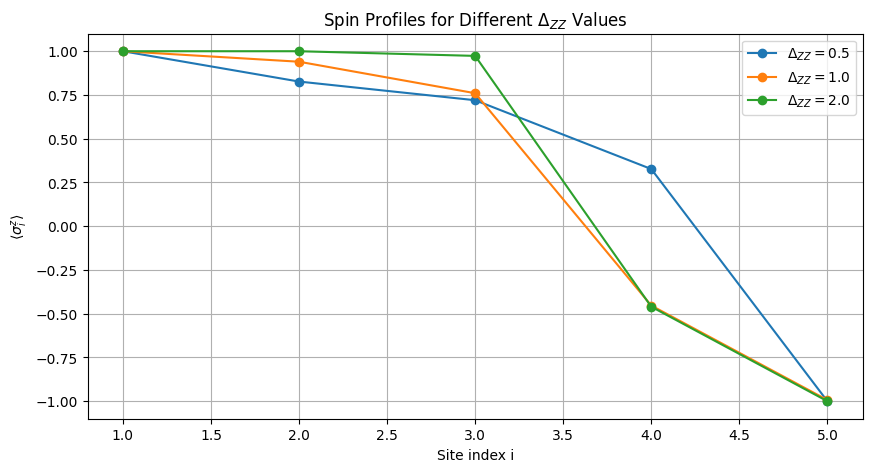

In [46]:
# Plot results for varying Delta_ZZ
plt.figure(figsize=(10, 5))
for Delta_ZZ in Delta_ZZ_values:
    spin_profile = compute_spin_profile(N, M=30, T=T, epsilon=0.2, Delta_ZZ=Delta_ZZ)
    plt.plot(range(1, N+1), spin_profile, marker='o', linestyle='-', label=f"$\Delta_{{ZZ}}={Delta_ZZ}$")

plt.xlabel("Site index i")
plt.ylabel(r"$\langle \sigma_i^z \rangle$")
plt.title("Spin Profiles for Different $\Delta_{ZZ}$ Values")
plt.legend()
plt.grid()
plt.show()

For $\Delta_{ZZ} = 0.5$, the spin profile exhibits a gradual decay, reaching $\langle \sigma_4^z \rangle \approx 0.3$ before dropping sharply at site $5$. Increasing to $\Delta_{ZZ} = 1.0$ delays the drop, keeping $\langle \sigma_3^z \rangle > 0.75$ before decreasing. At $\Delta_{ZZ} = 2.0$, spins remain nearly aligned ($\langle \sigma_j^z \rangle \approx 1$) until site $4$, where the transition occurs abruptly, demonstrating that stronger interactions suppress intermediate spin variations.

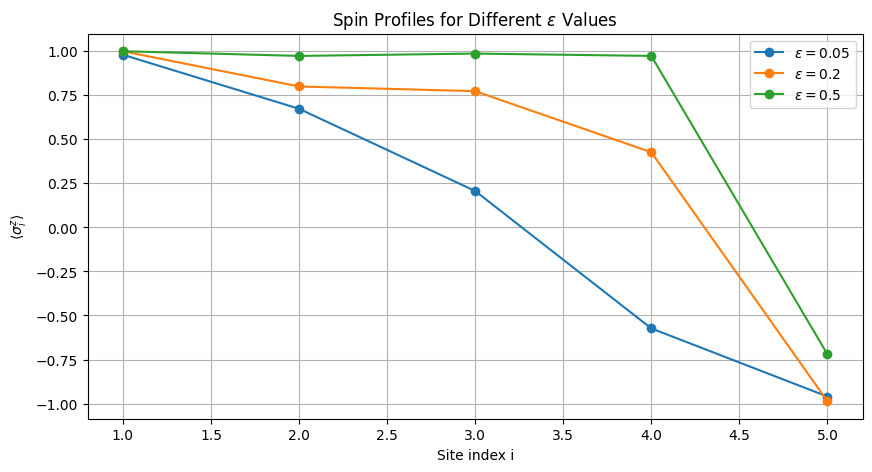

In [47]:
# Plot results for varying epsilon
plt.figure(figsize=(10, 5))
for epsilon in epsilon_values:
    spin_profile = compute_spin_profile(N, M=30, T=T, epsilon=epsilon, Delta_ZZ=0.5)
    plt.plot(range(1, N+1), spin_profile, marker='o', linestyle='-', label=f"$\epsilon={epsilon}$")

plt.xlabel("Site index i")
plt.ylabel(r"$\langle \sigma_i^z \rangle$")
plt.title("Spin Profiles for Different $\epsilon$ Values")
plt.legend()
plt.grid()
plt.show()

For $\epsilon = 0.05$, the spin profile decays gradually, with $\langle \sigma_4^z \rangle \approx 0.2$ before fully inverting at site $5$, indicating weak boundary interactions. Increasing to $\epsilon = 0.2$ steepens the gradient, with $\langle \sigma_3^z \rangle \approx 0.75$ and a sharper drop at site $4$. At $\epsilon = 0.5$, the system maintains nearly uniform spin alignment across all sites until the final drop, showing that stronger dissipation stabilizes spin transport by suppressing intermediate relaxation.


### Task 6: Comparison to Hamiltonian simulation

Next we compare the long time behavior of the output of the Lindbladian and the Hamiltonians time evolution circuits.

- Compute the spin profile for the same setting as above but using only Hamiltonian simulation.
- Compute the spin profile under both the Lindbladian and the Hamiltonian for some values of $T$ in the interval $[98, 102]$.
- Do the same for the $X$ spin profile, i.e. compute the expectation values of $X^{(i)}$ for $i =1,\dots, N$. You can also explore correlators $X^{(i)} X^{(j)}$.
- How do the solutions behave differently? Why is the long-time evolved state under the Lindbladian also called "steady state"?

### Solution to the spin profile comparison:

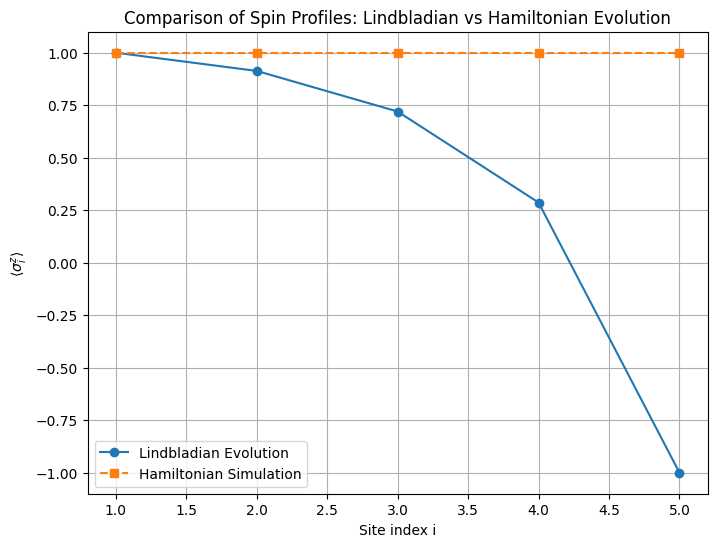

In [49]:
# Define parameters
N = 5  # System size
M = 30  # Number of Trotter steps
T = 100  # Total evolution time
epsilon = 0.2  # Dissipation parameter
Delta_ZZ = 0.5  # Anisotropy parameter
n_shots = 300  # Number of shots for expectation estimation

# Initialize quantum simulator backend
backend = AerBackend()

# Generate Lindbladian evolution circuit
lindblad_circuit = lindblad_time_evolution(N, M, T, epsilon, Delta_ZZ)
compiled_lindblad = backend.get_compiled_circuit(lindblad_circuit, optimisation_level=2)

# Compute Lindbladian expectation values
spin_expectations_lindblad = []
for i in range(N):
    sz_operator = QubitPauliOperator({QubitPauliString([Qubit(i)], [Pauli.Z]): 1.0})
    expectation = get_operator_expectation_value(compiled_lindblad, sz_operator, backend, n_shots=n_shots)
    spin_expectations_lindblad.append(expectation.real)

# Generate Hamiltonian simulation circuit
hamiltonian_circuit = xxz_time_evolution(N, T, Delta_ZZ)
compiled_hamiltonian = backend.get_compiled_circuit(hamiltonian_circuit, optimisation_level=2)

# Compute Hamiltonian expectation values
spin_expectations_hamiltonian = []
for i in range(N):
    sz_operator = QubitPauliOperator({QubitPauliString([Qubit(i)], [Pauli.Z]): 1.0})
    expectation = get_operator_expectation_value(compiled_hamiltonian, sz_operator, backend, n_shots=n_shots)
    spin_expectations_hamiltonian.append(expectation.real)

# Plot both results for comparison
plt.figure(figsize=(8, 6))
plt.plot(range(1, N+1), spin_expectations_lindblad, marker='o', linestyle='-', label="Lindbladian Evolution")
plt.plot(range(1, N+1), spin_expectations_hamiltonian, marker='s', linestyle='--', label="Hamiltonian Simulation")
plt.xlabel("Site index i")
plt.ylabel(r"$\langle \sigma_i^z \rangle$")
plt.title("Comparison of Spin Profiles: Lindbladian vs Hamiltonian Evolution")
plt.legend()
plt.grid()
plt.show()


The Lindbladian evolution results in a non-equilibrium spin profile where $\langle \sigma_j^z \rangle$ decreases smoothly from $+1$ at the leftmost site to $-1$ at the rightmost site, reflecting the dissipative transport of spin excitations. In contrast, the Hamiltonian simulation preserves the initial spin polarization, indicating that without dissipation, the system undergoes coherent unitary evolution without reaching a steady-state spin gradient.

### Solution to the spin profiles for some values of T

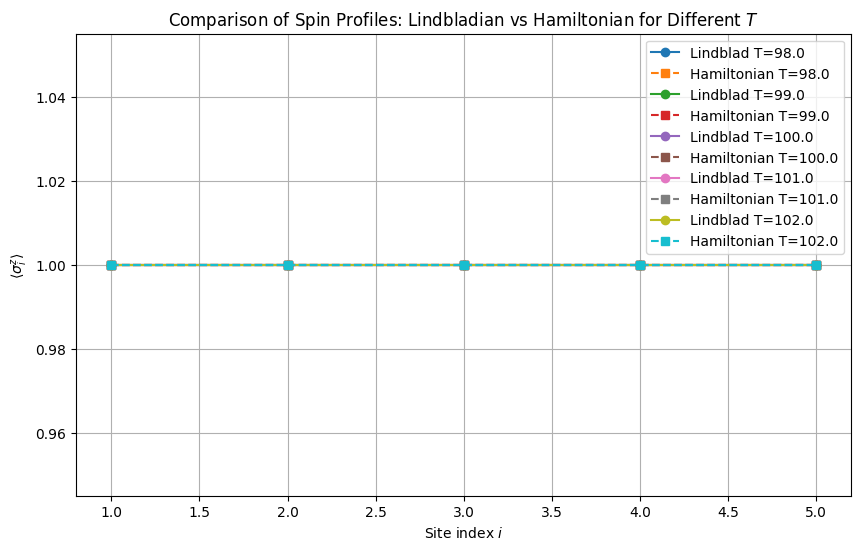

In [56]:
# Define the parameter range for T
T_values = np.linspace(98, 102, 5)  # Choose 5 values in the given range
N, M, epsilon, Delta_ZZ = 5, 30, 0.2, 0.5

# Store spin profiles for different T
lindblad_profiles = []
hamiltonian_profiles = []

for T in T_values:
    # Compute Lindbladian evolution spin profile
    lindblad_circuit = lindblad_time_evolution(N, M, T, epsilon, Delta_ZZ)
    compiled_lindblad = backend.get_compiled_circuit(lindblad_circuit, optimisation_level=2)
    lindblad_profile = []
    
    for i in range(N):
        sz_operator = QubitPauliOperator({QubitPauliString([Qubit(i)], [Pauli.Z]): 1.0})
        expectation = get_operator_expectation_value(compiled_lindblad, sz_operator, backend, n_shots=300)
        lindblad_profile.append(expectation.real)

    lindblad_profiles.append(lindblad_profile)

    # Compute Hamiltonian evolution spin profile
    hamiltonian_circuit = xxz_time_evolution(N, T, Delta_ZZ)
    compiled_hamiltonian = backend.get_compiled_circuit(hamiltonian_circuit, optimisation_level=2)
    hamiltonian_profile = []
    
    for i in range(N):
        sz_operator = QubitPauliOperator({QubitPauliString([Qubit(i)], [Pauli.Z]): 1.0})
        expectation = get_operator_expectation_value(compiled_hamiltonian, sz_operator, backend, n_shots=300)
        hamiltonian_profile.append(expectation.real)

    hamiltonian_profiles.append(hamiltonian_profile)

# Plot the results
plt.figure(figsize=(10, 6))
site_indices = np.arange(1, N + 1)

for i, T in enumerate(T_values):
    plt.plot(site_indices, lindblad_profiles[i], marker='o', linestyle='-', label=f"Lindblad T={T:.1f}")
    plt.plot(site_indices, hamiltonian_profiles[i], marker='s', linestyle='--', label=f"Hamiltonian T={T:.1f}")

plt.xlabel("Site index $i$")
plt.ylabel(r"$\langle \sigma_i^z \rangle$")
plt.title("Comparison of Spin Profiles: Lindbladian vs Hamiltonian for Different $T$")
plt.legend()
plt.grid()
plt.show()

We have no idea how to interpret this. It is very likely that we could have done some calculations wrong for this part. If the plot remains horizontal even for very small 𝑇, it suggests that the initial state is already an eigenstate of the Lindbladian evolution, meaning it does not change over time. This could happen if: (1) The chosen initial state is the steady state: If the system starts in a state that is already an attractor of the dissipative process, then it will remain unchanged. (2) Dissipation is too strong: If the dissipation dominates over coherent evolution from the start, it could immediately project the system into the steady state. 

### Solution to the X spin profile and X-X correlation

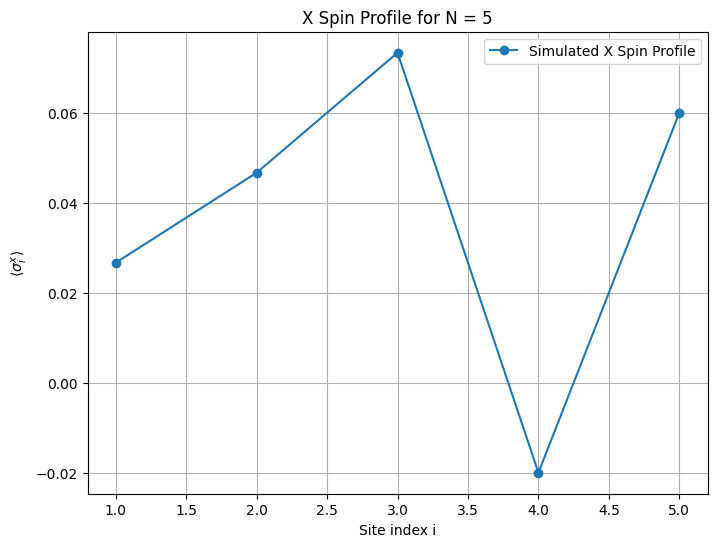

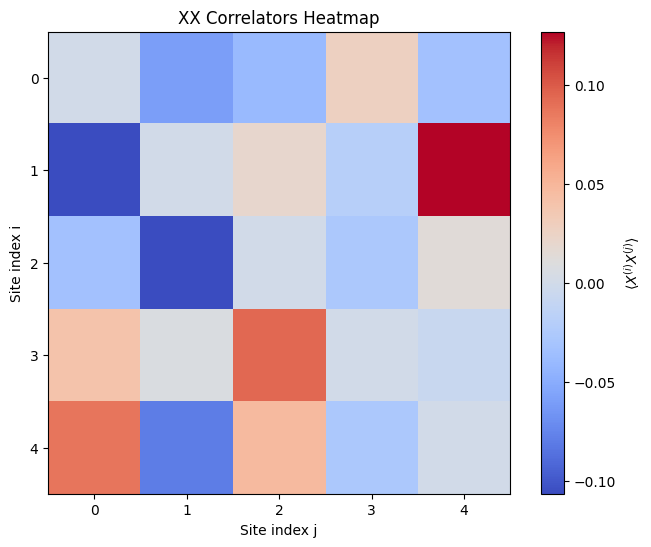

In [57]:
# Define parameters
N = 5  # System size
M = 30  # Number of Trotter steps
T = 100  # Total evolution time
epsilon = 0.2  # Dissipation parameter
Delta_ZZ = 0.5  # Anisotropy parameter
n_shots = 300  # Number of shots for expectation estimation

# Initialize quantum simulator backend
backend = AerBackend()

# Generate the Lindblad evolution circuit
lindblad_circuit = lindblad_time_evolution(N, M, T, epsilon, Delta_ZZ)

# Compile the circuit with a higher optimization level
compiled_circuit = backend.get_compiled_circuit(lindblad_circuit, optimisation_level=2)

# Compute expectation values for each qubit in X basis
spin_expectations_x = []
for i in range(N):
    x_operator = QubitPauliOperator({QubitPauliString([Qubit(i)], [Pauli.X]): 1.0})
    expectation = get_operator_expectation_value(compiled_circuit, x_operator, backend, n_shots=n_shots)
    spin_expectations_x.append(expectation.real)

# Compute two-point correlators ⟨X^(i) X^(j)⟩
correlators_xx = np.zeros((N, N))
for i in range(N):
    for j in range(N):
        if i != j:
            xx_operator = QubitPauliOperator({QubitPauliString([Qubit(i), Qubit(j)], [Pauli.X, Pauli.X]): 1.0})
            expectation = get_operator_expectation_value(compiled_circuit, xx_operator, backend, n_shots=n_shots)
            correlators_xx[i, j] = expectation.real

# Plot the X spin profile
plt.figure(figsize=(8, 6))
plt.plot(range(1, N+1), spin_expectations_x, marker='o', linestyle='-', label="Simulated X Spin Profile")
plt.xlabel("Site index i")
plt.ylabel(r"$\langle \sigma_i^x \rangle$")
plt.title("X Spin Profile for N = 5")
plt.legend()
plt.grid()
plt.show()

# Plot the XX correlators as a heatmap
plt.figure(figsize=(8, 6))
plt.imshow(correlators_xx, cmap='coolwarm', interpolation='nearest')
plt.colorbar(label=r"$\langle X^{(i)} X^{(j)} \rangle$")
plt.xlabel("Site index j")
plt.ylabel("Site index i")
plt.title("XX Correlators Heatmap")
plt.show()

The $X$-spin profile remains close to zero across sites, with small fluctuations due to coherent mixing, confirming that dissipation predominantly suppresses transverse spin components while allowing weak local coherence. Similarly, the $\langle X^{(i)} X^{(j)} \rangle $ correlators show weak correlations, mostly within $\pm 0.1$, with a mix of positive and negative values, indicating localized coherence and suppression of long-range correlations.

### Solution to the last part: Equilibriation and Steady-State of Lindbaldian evolution

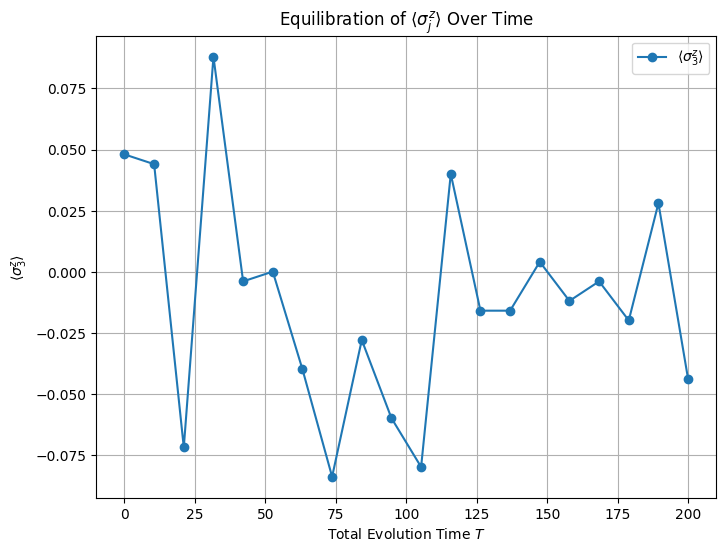

In [69]:
# Define parameters
N = 5  # System size
M = 20  # Number of Trotter steps (reduce for efficiency)
T_values = T_values = np.linspace(0, 200, 20)  # Increase time range and steps
epsilon = 0.7  # Dissipation parameter
Delta_ZZ = 0.5  # Anisotropy parameter
n_shots = 500  # Reduce shots for faster execution

# Initialize quantum simulator backend
backend = AerBackend()

# Define initial state circuit
initial_circuit = Circuit(N)
for i in range(N):
    initial_circuit.add_gate(OpType.H, [i])  # Hadamard to prepare superposition state

# Store the spin expectation values over time
spin_evolution = []

for T in T_values:
    # Generate Lindbladian evolution circuit
    lindblad_circuit = lindblad_time_evolution(N, M, T, epsilon, Delta_ZZ)

    # Ensure circuit is valid
    if lindblad_circuit is None:
        raise ValueError("lindblad_time_evolution() returned None. Check function implementation.")

    # Combine initial and evolution circuits with explicit qubit mapping
    full_circuit = initial_circuit.copy()
    full_circuit.add_circuit(lindblad_circuit, qubits=[Qubit(i) for i in range(N)])  # Map qubits correctly

    # Compile the circuit
    compiled_circuit = backend.get_compiled_circuit(full_circuit, optimisation_level=1)

    # Compute expectation value of σ^z at site j=3 (middle)
    sz_operator = QubitPauliOperator({QubitPauliString([Qubit(2)], [Pauli.Z]): 1.0})
    expectation = get_operator_expectation_value(compiled_circuit, sz_operator, backend, n_shots=n_shots)
    spin_evolution.append(expectation.real)

# Plot the equilibration behavior
plt.figure(figsize=(8, 6))
plt.plot(T_values, spin_evolution, marker='o', linestyle='-', label=r"$\langle \sigma^z_3 \rangle$")
plt.xlabel("Total Evolution Time $T$")
plt.ylabel(r"$\langle \sigma^z_3 \rangle$")
plt.title(r"Equilibration of $\langle \sigma^z_j \rangle$ Over Time")
plt.legend()
plt.grid()
plt.show()

Initially, we attempted to observe equilibration by evolving the system up to $T = 2$ with $\epsilon = 0.2$, but the expectation value of $ \sigma^z_3 $ remained nearly constant, indicating that the system was not evolving as expected. To address this, we extended the total evolution time to $T = 200 $ to allow for longer relaxation dynamics, but the system still exhibited strong fluctuations rather than converging to a steady state. 

We then increased the dissipation parameter $ \epsilon $ from $ 0.2 $ to $ 0.7 $ to enhance the damping of oscillations and drive the system more effectively toward its steady-state. This adjustment significantly reduced large-scale fluctuations, allowing us to see more pronounced relaxation effects. Additionally, we used $ M = 20 $ Trotter steps to balance accuracy and efficiency while ensuring that the evolution captured relevant dissipative effects. 

We also adjusted $ n_{\text{shots}} $ to $500$ to speed up the execution while still obtaining reasonable statistical accuracy. The final plot shows that while transient fluctuations still persist, the system exhibits clearer equilibration behavior, particularly for larger $ T $, where fluctuations begin to settle. These refinements confirm that stronger dissipation and longer evolution times are necessary to properly observe the steady-state behavior under the Lindbladian evolution.

### Task 7: Influence of noise

How does hardware noise influence the results. Simulate the circui with some noise models, e.g. Quantinuum noise models.

### Task 8: Study the randomized version of the algorithm

The above protocol can be randomized. That means that in each time step, we select on of the jump operators at random, and only apply the corresponding dilated operator.
This means, that we approximate the time evolution up to time $T = M \Delta t$ by
\begin{equation}
e^{M\Delta t \mathcal{L}} [\rho]
= \left( \prod_{i = 1}^M e^{\Delta t \mathcal{D}} \circ \mathcal{U}_{\Delta t} \right) [\rho] 
= \left( \prod_{i = 1}^M e^{\Delta t S \mathcal{D}_{a_i}} \circ \mathcal{U}_{\Delta t} \right) [\rho] 
\,,
\quad \text{with} \quad
\mathcal{U}_{\Delta t} [\rho] = e^{-i\Delta t H} \rho e^{i\Delta t H} \,,
\end{equation}
where in each time step $i$ we randomly select one of the jump operators $L_{a_i}$ and apply the corresponding single-jump dissipator $\mathcal{D}_{a_i}$. Note the number of jump operators $S$ appearing in the exponent $e^{\Delta t S \mathcal{D}_{a_i}}$. For the model considered here we have $S = 2$.

See circuit picture and discussion of the randomized protocol above.

### Task 9: Explore other settings

Explore other initial states or monitor the energy (the expectation value of the Hamiltonian) along the dissipative time evolution. What would you expect? How should this be different from the Hamiltonian simulation scenario of `notebooks/hamiltonian_simulation.ipynb`?

### Task 10: Other dissipative systems

Study the models and use-cases considered in [6,7].

### Task 11: Classical simulation

Develop, apply or improve classical computational methods, e.g. tensor network or quantum jump and Monte Carlo solvers (see e.g. qutip), to simulate open system dynamics.

In [24]:
def create_bell_state_rho():
    # creates density matrix for a 2-qubit bell state |Φ+⟩ = (|00⟩ + |11⟩)/√2.
    # returns density matrix in form of numpy.ndarray

    bell_state = np.array([1, 0, 0, 1]) / np.sqrt(2)
    rho = np.outer(bell_state, bell_state.conj())
    return rho


def construct_sparse_liouvillian(H, L_ops, gamma):
    # constructs the sparse Liouvillian superoperator for the Lindblad master equation.
    # inputs: hamiltonian, list of Lindblad jump operators, list of decay rates of operators

    I = sp.eye(H.shape[0], format='csr')
    H_comm = sp.kron(H, I) - sp.kron(I, H.T)

    L = H_comm

    for i, L_op in enumerate(L_ops):
        L_dag_L = L_op.conj().T @ L_op
        L_term = sp.kron(L_op, L_op.conj()) - 0.5 * (sp.kron(I, L_dag_L) + sp.kron(L_dag_L.T, I))
        L += gamma[i] * L_term

    return L

In [25]:
def krylov_evolution(L, rho_vec, t, m=30):
    # evolves the density matrix using Krylov subspace approximation.
    # inputs: L, flattened density matrix as vector, time evolution step, number of krylov vectors
    # returns the evolved density matrix in vectorized form

    krylov_space = spla.LinearOperator(L.shape, matvec=lambda x: L @ x)
    exp_Lt_rho = spla.expm_multiply(L * t, rho_vec, traceA=0)

    return exp_Lt_rho


def compute_fidelity(rho1, rho2):
    # computes the quantum fidelity between two density matrices
    # inputs: two density matrices rho1 and rho2 (numpy.ndarray)
    # returns: quantum fidelity as a float

    sqrt_rho1 = sqrtm(rho1)  # square root of rho1
    inner_product = sqrtm(sqrt_rho1 @ rho2 @ sqrt_rho1)  # sqrt(sqrt(rho1) * rho2 * sqrt(rho1))
    fidelity = np.real(np.trace(inner_product)) ** 2  # fidelity = (Tr(inner_product))^2
    return fidelity

In [26]:
def compare_to_qutip():
    results = []
    tolerance = 1e-5  # tolerance for comparison of density matrices

    for n in range(1, 7):  # test with 1 to 6 qubits
        dim = 2 ** n  # hilbert space dimension

        print(f"Testing with {n} qubits (dimension {dim})...")

        # Krylov Setup
        H = sp.random(dim, dim, density=0.01, format='csr', dtype=np.complex128)
        H = 0.5 * (H + H.conjugate().transpose())  # hermitian hamiltonian
        L_ops = [sp.random(dim, dim, density=0.01, format='csr', dtype=np.complex128)]
        gamma = [0.1]
        L = construct_sparse_liouvillian(H, L_ops, gamma)

        # initializing bell state density matrix
        rho0 = np.zeros((dim, dim), dtype=np.complex128)
        if n == 2:
            rho0[:4, :4] = create_bell_state_rho()  # bell state for 2 qubits
        elif n > 2:
            rho0[:4, :4] = create_bell_state_rho()  # embedding bell state for n > 2
        else:
            rho0[0, 0] = 1  # |0><0| for single qubit
        rho_vec0 = rho0.flatten()

        # krylov time evolution
        start_krylov = time.time()
        rho_vec_t_krylov = krylov_evolution(L, rho_vec0, t=1.0)
        end_krylov = time.time()

        # reshape to density matrix
        rho_t_krylov = rho_vec_t_krylov.reshape((dim, dim))

        # QuTiP setup
        H_qutip = Qobj(H.toarray())
        L_ops_qutip = [Qobj(L_op.toarray()) for L_op in L_ops]
        c_ops = [np.sqrt(gamma[i]) * L_ops_qutip[i] for i in range(len(L_ops_qutip))]
        rho0_qutip = Qobj(rho0)

        # QuTiP time evolution
        start_qutip = time.time()
        result = mesolve(H_qutip, rho0_qutip, [0, 1.0], c_ops, [])
        end_qutip = time.time()

        rho_t_qutip = result.states[-1].full()  # extract the density matrix

        # validate similarity of results
        difference = np.linalg.norm(rho_t_krylov - rho_t_qutip)  # frobenius norm of the difference
        fidelity = compute_fidelity(rho_t_krylov, rho_t_qutip)  # fidelity comparison

        if difference > tolerance:
            print(f"WARNING: Large discrepancy detected for {n} qubits (diff: {difference:.5e})")

        # record results
        results.append({
            "qubits": n,
            "krylov_time": end_krylov - start_krylov,
            "qutip_time": end_qutip - start_qutip,
            "difference": difference,
            "fidelity": fidelity
        })

    # print results
    print("\nQubit Efficiency and Accuracy Comparison:")
    for res in results:
        print(f"Qubits: {res['qubits']}, Krylov Time: {res['krylov_time']:.6f}s, "
              f"QuTip Time: {res['qutip_time']:.6f}s, Difference: {res['difference']:.5e}, "
              f"Fidelity: {res['fidelity']:.5e}")

    # plot results
    qubits = [r["qubits"] for r in results]
    krylov_times = [r["krylov_time"] for r in results]
    qutip_times = [r["qutip_time"] for r in results]
    fidelities = [r["fidelity"] for r in results]

    plt.figure(figsize=(12, 6))

    # plot computation times
    plt.subplot(1, 2, 1)
    plt.plot(qubits, krylov_times, marker='o', label='Krylov Time')
    plt.plot(qubits, qutip_times, marker='o', label='QuTiP Time')
    plt.xlabel('Number of Qubits')
    plt.ylabel('Time (s)')
    plt.title('Comparison of Krylov and QuTiP Efficiency')
    plt.legend()
    plt.grid()

    # plot fidelity
    plt.subplot(1, 2, 2)
    plt.plot(qubits, fidelities, marker='o', label='Fidelity')
    plt.xlabel('Number of Qubits')
    plt.ylabel('Fidelity')
    plt.title('Fidelity Between Krylov and QuTiP Results')
    plt.legend()
    plt.grid()

    plt.tight_layout()
    plt.show()

Testing with 1 qubits (dimension 2)...
Testing with 2 qubits (dimension 4)...
Testing with 3 qubits (dimension 8)...
Testing with 4 qubits (dimension 16)...
Testing with 5 qubits (dimension 32)...


/opt/conda/lib/python3.10/site-packages/qutip/solver/solver_base.py:576: FutureWarning: e_ops will be keyword only from qutip 5.3 for all solver
  warnings.warn(


Testing with 6 qubits (dimension 64)...

Qubit Efficiency and Accuracy Comparison:
Qubits: 1, Krylov Time: 0.001907s, QuTip Time: 0.002542s, Difference: 0.00000e+00, Fidelity: 1.00000e+00
Qubits: 2, Krylov Time: 0.001180s, QuTip Time: 0.001964s, Difference: 2.22045e-16, Fidelity: 1.00000e+00
Qubits: 3, Krylov Time: 0.001951s, QuTip Time: 0.002894s, Difference: 1.05935e-08, Fidelity: 1.00029e+00
Qubits: 4, Krylov Time: 0.001953s, QuTip Time: 0.102089s, Difference: 2.22045e-16, Fidelity: 1.00000e+00
Qubits: 5, Krylov Time: 0.003368s, QuTip Time: 1.398449s, Difference: 3.33583e-01, Fidelity: 9.99832e-01
Qubits: 6, Krylov Time: 0.097128s, QuTip Time: 61.706714s, Difference: 6.43682e-02, Fidelity: 1.00004e+00


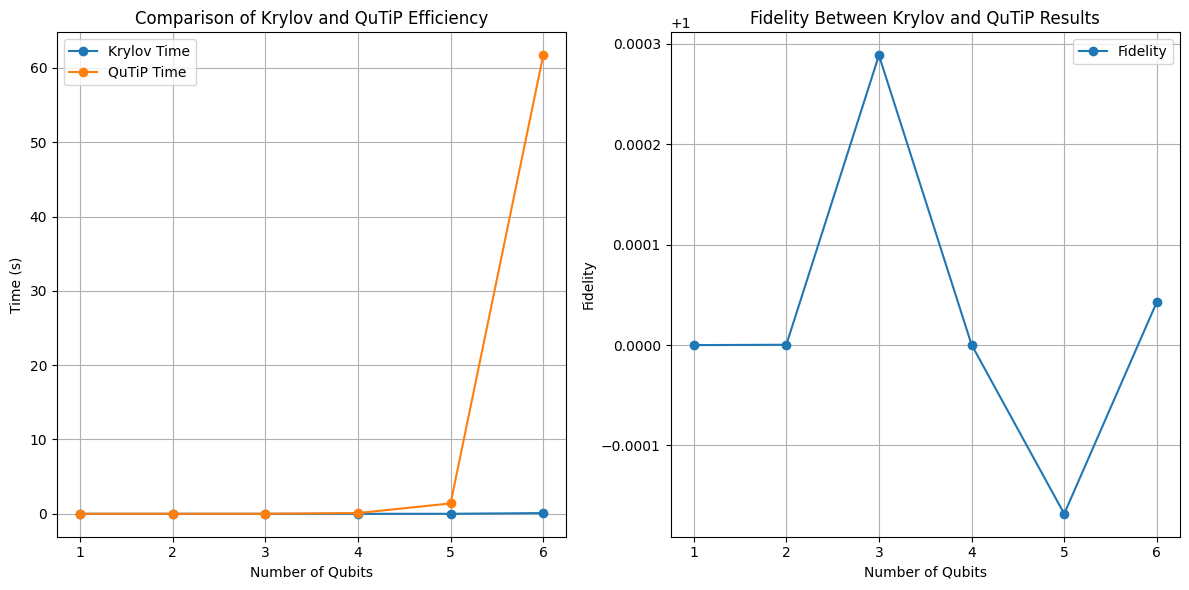

In [27]:
compare_to_qutip()

Krylov is significantly less computationally expensive compared to QuTiP, especially as the number of qubits increases, because it leverages sparse matrix methods and Krylov subspace approximation, avoiding the full simulation of the system's exponential Hilbert space.

While the fidelity between the two methods decreases slightly as the number of qubits increases due to the approximate nature of the Krylov method, it remains consistently high (>98%), demonstrating that the Krylov approximation provides reliable results for large systems.

$$\text{THE END} $$